In [1]:
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import seaborn as sns
import xarray as xr

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
!pwd

/work/scripts/caribou-poker-exp


In [4]:
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [5]:
#establish site coordinates

run_name='BONA-birch'

station_lat = 65.15401 #caribou creek
station_lon = -147.50258 #caribou creek

#get netcdf coordinates from runmask
#runmask = nc.Dataset('/data/workflows/BONA-birch/run-mask.nc') #original climate dataset
runmask = nc.Dataset('/data/input-catalog/cpcrw_towers_downscaled/run-mask.nc') #downscaled climate dataset
lats=runmask.variables['lat'][:]
lons=runmask.variables['lon'][:]

#get distance between station and each cell
ydist = lats-station_lat
xdist = lons-station_lon
euc_dist = (ydist**2 + xdist**2)**.5

y_x = np.unravel_index(np.argmin(euc_dist),np.shape(lats))
print('y coordinate: {}'.format(y_x[0]))
print('x coordinate: {}'.format(y_x[1]))

y coordinate: 0
x coordinate: 0


# BONA Birch

In [6]:
!rm -r /data/workflows/BONA-birch/

In [7]:
%cd /work

/work


In [8]:
#set working directory, original input
#!scripts/setup_working_directory.py \
#--input-data-path /data/input-catalog/caribou-poker_merged/ \
#/data/workflows/BONA-birch/

In [9]:
#set working directory, downscaled input
!scripts/util/setup_working_directory.py \
--input-data-path /data/input-catalog/cpcrw_towers_downscaled/ \
/data/workflows/BONA-birch/

turning off dsb


In [10]:
# Adjust the config file
CONFIG_FILE = os.path.join('/data/workflows/BONA-birch/', 'config/config.js')
# Read the existing data into memory
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)
    
    config['IO']['output_nc_eq'] = 1 # Modify value...

# Write it back..
with open(CONFIG_FILE, 'w') as f:
    json.dump(config, f, indent=2)

In [11]:
#poker flats: 0, 1
#caribou creek: 3, 0 # original climate
#caribou creek: 0, 0, #downscaled climate
# setup runmask
!runmask.py --reset \
--yx 0 0 \
--show \
/data/workflows/BONA-birch/run-mask.nc

/usr/bin/sh: 1: runmask.py: not found


In [12]:
path_to_soil_input='/data/input-catalog/cpcrw_towers_downscaled/soil-texture.nc'
soil_dataset = nc.Dataset(path_to_soil_input)
print(soil_dataset)
print('target cell is {}% clay, {}% sand, and {}% silt'.format(soil_dataset['pct_clay'][y_x[0], y_x[1]], 
                                                               soil_dataset['pct_sand'][y_x[0], y_x[1]], 
                                                               soil_dataset['pct_silt'][y_x[0], y_x[1]]))
soil_dataset.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Y(1), X(1)
    variables(dimensions): int64 Y(Y), int64 X(X), float32 pct_sand(Y, X), float32 pct_clay(Y, X), float32 pct_silt(Y, X), int32 y(Y), int32 x(X), float32 lat(Y, X), float32 lon(Y, X)
    groups: 
target cell is 36.900001525878906% clay, 26.600000381469727% sand, and 36.5% silt


In [13]:
#soil_dataset = nc.Dataset(path_to_soil_input, 'r+')
#soil_dataset['pct_clay'][y_x[0], y_x[1]] = 10 # originally 8.81557846069336
#soil_dataset['pct_sand'][y_x[0], y_x[1]] = 27 # originally 42.533843994140625
#soil_dataset['pct_silt'][y_x[0], y_x[1]] = 63 # origially 48.650577545166016
#print('target cell is {}% clay, {}% sand, and {}% silt'.format(soil_dataset['pct_clay'][y_x[0], y_x[1]], 
#                                                               soil_dataset['pct_sand'][y_x[0], y_x[1]], 
#                                                               soil_dataset['pct_silt'][y_x[0], y_x[1]]))
#drainage.close()


In [14]:
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --empty
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on CMTNUM yearly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on GPP monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on RG monthly compartment
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on RH monthly layer
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on RM monthly compartment
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on NPP monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on ALD yearly 
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on SHLWC yearly monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on DEEPC yearly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on MINEC yearly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on ORGN yearly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on AVLN yearly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on LTRFALC monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on LWCLAYER monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on TLAYER monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on LAYERDEPTH monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on LAYERDZ monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on EET monthly
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on TRANSPIRATION monthly PFT
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on LAI monthly PFT
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on VEGC monthly PFT compartment
!scripts/util/outspec.py ../data/workflows/BONA-birch/config/output_spec.csv --on BURNVEG2AIRC monthly

In [15]:
%cd /data/workflows/BONA-birch

/data/workflows/BONA-birch


In [16]:
!dvmdostem --force-cmt=14 --log-level='err' --pr-yrs=100 --eq-yrs=1500 --sp-yrs=300 --tr-yrs=122 --sc-yrs=0

Setting up logging...
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 5
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 6
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 7
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 8
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 9
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 10
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 11
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 12
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err

[err] [EQ->Y] y: 0 x: 0 Year: 123
[err] [EQ->Y] y: 0 x: 0 Year: 124
[err] [EQ->Y] y: 0 x: 0 Year: 125
[err] [EQ->Y] y: 0 x: 0 Year: 126
[err] [EQ->Y] y: 0 x: 0 Year: 127
[err] [EQ->Y] y: 0 x: 0 Year: 128
[err] [EQ->Y] y: 0 x: 0 Year: 129
[err] [EQ->Y] y: 0 x: 0 Year: 130
[err] [EQ->Y] y: 0 x: 0 Year: 131
[err] [EQ->Y] y: 0 x: 0 Year: 132
[err] [EQ->Y] y: 0 x: 0 Year: 133
[err] [EQ->Y] y: 0 x: 0 Year: 134
[err] [EQ->Y] y: 0 x: 0 Year: 135
[err] [EQ->Y] y: 0 x: 0 Year: 136
[err] [EQ->Y] y: 0 x: 0 Year: 137
[err] [EQ->Y] y: 0 x: 0 Year: 138
[err] [EQ->Y] y: 0 x: 0 Year: 139
[err] [EQ->Y] y: 0 x: 0 Year: 140
[err] [EQ->Y] y: 0 x: 0 Year: 141
[err] [EQ->Y] y: 0 x: 0 Year: 142
[err] [EQ->Y] y: 0 x: 0 Year: 143
[err] [EQ->Y] y: 0 x: 0 Year: 144
[err] [EQ->Y] y: 0 x: 0 Year: 145
[err] [EQ->Y] y: 0 x: 0 Year: 146
[err] [EQ->Y] y: 0 x: 0 Year: 147
[err] [EQ->Y] y: 0 x: 0 Year: 148
[err] [EQ->Y] y: 0 x: 0 Year: 149
[err] [EQ->Y] y: 0 x: 0 Year: 150
[err] [EQ->Y] y: 0 x: 0 Year: 151
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 364
[err] [EQ->Y] y: 0 x: 0 Year: 365
[err] [EQ->Y] y: 0 x: 0 Year: 366
[err] [EQ->Y] y: 0 x: 0 Year: 367
[err] [EQ->Y] y: 0 x: 0 Year: 368
[err] [EQ->Y] y: 0 x: 0 Year: 369
[err] [EQ->Y] y: 0 x: 0 Year: 370
[err] [EQ->Y] y: 0 x: 0 Year: 371
[err] [EQ->Y] y: 0 x: 0 Year: 372
[err] [EQ->Y] y: 0 x: 0 Year: 373
[err] [EQ->Y] y: 0 x: 0 Year: 374
[err] [EQ->Y] y: 0 x: 0 Year: 375
[err] [EQ->Y] y: 0 x: 0 Year: 376
[err] [EQ->Y] y: 0 x: 0 Year: 377
[err] [EQ->Y] y: 0 x: 0 Year: 378
[err] [EQ->Y] y: 0 x: 0 Year: 379
[err] [EQ->Y] y: 0 x: 0 Year: 380
[err] [EQ->Y] y: 0 x: 0 Year: 381
[err] [EQ->Y] y: 0 x: 0 Year: 382
[err] [EQ->Y] y: 0 x: 0 Year: 383
[err] [EQ->Y] y: 0 x: 0 Year: 384
[err] [EQ->Y] y: 0 x: 0 Year: 385
[err] [EQ->Y] y: 0 x: 0 Year: 386
[err] [EQ->Y] y: 0 x: 0 Year: 387
[err] [EQ->Y] y: 0 x: 0 Year: 388
[err] [EQ->Y] y: 0 x: 0 Year: 389
[err] [EQ->Y] y: 0 x: 0 Year: 390
[err] [EQ->Y] y: 0 x: 0 Year: 391
[err] [EQ->Y] y: 0 x: 0 Year: 392
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 605
[err] [EQ->Y] y: 0 x: 0 Year: 606
[err] [EQ->Y] y: 0 x: 0 Year: 607
[err] [EQ->Y] y: 0 x: 0 Year: 608
[err] [EQ->Y] y: 0 x: 0 Year: 609
[err] [EQ->Y] y: 0 x: 0 Year: 610
[err] [EQ->Y] y: 0 x: 0 Year: 611
[err] [EQ->Y] y: 0 x: 0 Year: 612
[err] [EQ->Y] y: 0 x: 0 Year: 613
[err] [EQ->Y] y: 0 x: 0 Year: 614
[err] [EQ->Y] y: 0 x: 0 Year: 615
[err] [EQ->Y] y: 0 x: 0 Year: 616
[err] [EQ->Y] y: 0 x: 0 Year: 617
[err] [EQ->Y] y: 0 x: 0 Year: 618
[err] [EQ->Y] y: 0 x: 0 Year: 619
[err] [EQ->Y] y: 0 x: 0 Year: 620
[err] [EQ->Y] y: 0 x: 0 Year: 621
[err] [EQ->Y] y: 0 x: 0 Year: 622
[err] [EQ->Y] y: 0 x: 0 Year: 623
[err] [EQ->Y] y: 0 x: 0 Year: 624
[err] [EQ->Y] y: 0 x: 0 Year: 625
[err] [EQ->Y] y: 0 x: 0 Year: 626
[err] [EQ->Y] y: 0 x: 0 Year: 627
[err] [EQ->Y] y: 0 x: 0 Year: 628
[err] [EQ->Y] y: 0 x: 0 Year: 629
[err] [EQ->Y] y: 0 x: 0 Year: 630
[err] [EQ->Y] y: 0 x: 0 Year: 631
[err] [EQ->Y] y: 0 x: 0 Year: 632
[err] [EQ->Y] y: 0 x: 0 Year: 633
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 846
[err] [EQ->Y] y: 0 x: 0 Year: 847
[err] [EQ->Y] y: 0 x: 0 Year: 848
[err] [EQ->Y] y: 0 x: 0 Year: 849
[err] [EQ->Y] y: 0 x: 0 Year: 850
[err] [EQ->Y] y: 0 x: 0 Year: 851
[err] [EQ->Y] y: 0 x: 0 Year: 852
[err] [EQ->Y] y: 0 x: 0 Year: 853
[err] [EQ->Y] y: 0 x: 0 Year: 854
[err] [EQ->Y] y: 0 x: 0 Year: 855
[err] [EQ->Y] y: 0 x: 0 Year: 856
[err] [EQ->Y] y: 0 x: 0 Year: 857
[err] [EQ->Y] y: 0 x: 0 Year: 858
[err] [EQ->Y] y: 0 x: 0 Year: 859
[err] [EQ->Y] y: 0 x: 0 Year: 860
[err] [EQ->Y] y: 0 x: 0 Year: 861
[err] [EQ->Y] y: 0 x: 0 Year: 862
[err] [EQ->Y] y: 0 x: 0 Year: 863
[err] [EQ->Y] y: 0 x: 0 Year: 864
[err] [EQ->Y] y: 0 x: 0 Year: 865
[err] [EQ->Y] y: 0 x: 0 Year: 866
[err] [EQ->Y] y: 0 x: 0 Year: 867
[err] [EQ->Y] y: 0 x: 0 Year: 868
[err] [EQ->Y] y: 0 x: 0 Year: 869
[err] [EQ->Y] y: 0 x: 0 Year: 870
[err] [EQ->Y] y: 0 x: 0 Year: 871
[err] [EQ->Y] y: 0 x: 0 Year: 872
[err] [EQ->Y] y: 0 x: 0 Year: 873
[err] [EQ->Y] y: 0 x: 0 Year: 874
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 1085
[err] [EQ->Y] y: 0 x: 0 Year: 1086
[err] [EQ->Y] y: 0 x: 0 Year: 1087
[err] [EQ->Y] y: 0 x: 0 Year: 1088
[err] [EQ->Y] y: 0 x: 0 Year: 1089
[err] [EQ->Y] y: 0 x: 0 Year: 1090
[err] [EQ->Y] y: 0 x: 0 Year: 1091
[err] [EQ->Y] y: 0 x: 0 Year: 1092
[err] [EQ->Y] y: 0 x: 0 Year: 1093
[err] [EQ->Y] y: 0 x: 0 Year: 1094
[err] [EQ->Y] y: 0 x: 0 Year: 1095
[err] [EQ->Y] y: 0 x: 0 Year: 1096
[err] [EQ->Y] y: 0 x: 0 Year: 1097
[err] [EQ->Y] y: 0 x: 0 Year: 1098
[err] [EQ->Y] y: 0 x: 0 Year: 1099
[err] [EQ->Y] y: 0 x: 0 Year: 1100
[err] [EQ->Y] y: 0 x: 0 Year: 1101
[err] [EQ->Y] y: 0 x: 0 Year: 1102
[err] [EQ->Y] y: 0 x: 0 Year: 1103
[err] [EQ->Y] y: 0 x: 0 Year: 1104
[err] [EQ->Y] y: 0 x: 0 Year: 1105
[err] [EQ->Y] y: 0 x: 0 Year: 1106
[err] [EQ->Y] y: 0 x: 0 Year: 1107
[err] [EQ->Y] y: 0 x: 0 Year: 1108
[err] [EQ->Y] y: 0 x: 0 Year: 1109
[err] [EQ->Y] y: 0 x: 0 Year: 1110
[err] [EQ->Y] y: 0 x: 0 Year: 1111
[err] [EQ->Y] y: 0 x: 0 Year: 1112
[err] [EQ->Y] y: 0 x

[err] [EQ->Y] y: 0 x: 0 Year: 1320
[err] [EQ->Y] y: 0 x: 0 Year: 1321
[err] [EQ->Y] y: 0 x: 0 Year: 1322
[err] [EQ->Y] y: 0 x: 0 Year: 1323
[err] [EQ->Y] y: 0 x: 0 Year: 1324
[err] [EQ->Y] y: 0 x: 0 Year: 1325
[err] [EQ->Y] y: 0 x: 0 Year: 1326
[err] [EQ->Y] y: 0 x: 0 Year: 1327
[err] [EQ->Y] y: 0 x: 0 Year: 1328
[err] [EQ->Y] y: 0 x: 0 Year: 1329
[err] [EQ->Y] y: 0 x: 0 Year: 1330
[err] [EQ->Y] y: 0 x: 0 Year: 1331
[err] [EQ->Y] y: 0 x: 0 Year: 1332
[err] [EQ->Y] y: 0 x: 0 Year: 1333
[err] [EQ->Y] y: 0 x: 0 Year: 1334
[err] [EQ->Y] y: 0 x: 0 Year: 1335
[err] [EQ->Y] y: 0 x: 0 Year: 1336
[err] [EQ->Y] y: 0 x: 0 Year: 1337
[err] [EQ->Y] y: 0 x: 0 Year: 1338
[err] [EQ->Y] y: 0 x: 0 Year: 1339
[err] [EQ->Y] y: 0 x: 0 Year: 1340
[err] [EQ->Y] y: 0 x: 0 Year: 1341
[err] [EQ->Y] y: 0 x: 0 Year: 1342
[err] [EQ->Y] y: 0 x: 0 Year: 1343
[err] [EQ->Y] y: 0 x: 0 Year: 1344
[err] [EQ->Y] y: 0 x: 0 Year: 1345
[err] [EQ->Y] y: 0 x: 0 Year: 1346
[err] [EQ->Y] y: 0 x: 0 Year: 1347
[err] [EQ->Y] y: 0 x

[err] [SP->Y] y: 0 x: 0 Year: 52
[err] [SP->Y] y: 0 x: 0 Year: 53
[err] [SP->Y] y: 0 x: 0 Year: 54
[err] [SP->Y] y: 0 x: 0 Year: 55
[err] [SP->Y] y: 0 x: 0 Year: 56
[err] [SP->Y] y: 0 x: 0 Year: 57
[err] [SP->Y] y: 0 x: 0 Year: 58
[err] [SP->Y] y: 0 x: 0 Year: 59
[err] [SP->Y] y: 0 x: 0 Year: 60
[err] [SP->Y] y: 0 x: 0 Year: 61
[err] [SP->Y] y: 0 x: 0 Year: 62
[err] [SP->Y] y: 0 x: 0 Year: 63
[err] [SP->Y] y: 0 x: 0 Year: 64
[err] [SP->Y] y: 0 x: 0 Year: 65
[err] [SP->Y] y: 0 x: 0 Year: 66
[err] [SP->Y] y: 0 x: 0 Year: 67
[err] [SP->Y] y: 0 x: 0 Year: 68
[err] [SP->Y] y: 0 x: 0 Year: 69
[err] [SP->Y] y: 0 x: 0 Year: 70
[err] [SP->Y] y: 0 x: 0 Year: 71
[err] [SP->Y] y: 0 x: 0 Year: 72
[err] [SP->Y] y: 0 x: 0 Year: 73
[err] [SP->Y] y: 0 x: 0 Year: 74
[err] [SP->Y] y: 0 x: 0 Year: 75
[err] [SP->Y] y: 0 x: 0 Year: 76
[err] [SP->Y] y: 0 x: 0 Year: 77
[err] [SP->Y] y: 0 x: 0 Year: 78
[err] [SP->Y] y: 0 x: 0 Year: 79
[err] [SP->Y] y: 0 x: 0 Year: 80
[err] [SP->Y] y: 0 x: 0 Year: 81
[err] [SP-

[err] [SP->Y] y: 0 x: 0 Year: 295
[err] [SP->Y] y: 0 x: 0 Year: 296
[err] [SP->Y] y: 0 x: 0 Year: 297
[err] [SP->Y] y: 0 x: 0 Year: 298
[err] [SP->Y] y: 0 x: 0 Year: 299
[fatal] [TR] Running Transient, 122 years
[err] [TR]  (Remaining Layers...)
[err] [TR] after parent layers :5
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[err] [TR->Y] y: 0 x: 0 Year: 5
[err] [TR->Y] y: 0 x: 0 Year: 6
[err] [TR->Y] y: 0 x: 0 Year: 7
[err] [TR->Y] y: 0 x: 0 Year: 8
[err] [TR->Y] y: 0 x: 0 Year: 9
[err] [TR->Y] y: 0 x: 0 Year: 10
[err] [TR->Y] y: 0 x: 0 Year: 11
[err] [TR->Y] y: 0 x: 0 Year: 12
[err] [TR->Y] y: 0 x: 0 Year: 13
[err] [TR->Y] y: 0 x: 0 Year: 14
[err] [TR->Y] y: 0 x: 0 Year: 15
[err] [TR->Y] y: 0 x: 0 Year: 16
[err] [TR->Y] y: 0 x: 0 Year: 17
[err] [TR->Y] y: 0 x: 0 Year: 18
[err] [TR->Y] y: 0 x: 0 Year: 19
[err] [TR->

In [17]:
!ls /data/workflows/BONA-birch/output/

ALD_yearly_eq.nc	    MINEC_yearly_eq.nc
ALD_yearly_sp.nc	    MINEC_yearly_sp.nc
ALD_yearly_tr.nc	    MINEC_yearly_tr.nc
AVLN_yearly_eq.nc	    NPP_monthly_eq.nc
AVLN_yearly_sp.nc	    NPP_monthly_sp.nc
AVLN_yearly_tr.nc	    NPP_monthly_tr.nc
BURNVEG2AIRC_monthly_eq.nc  ORGN_yearly_eq.nc
BURNVEG2AIRC_monthly_sp.nc  ORGN_yearly_sp.nc
BURNVEG2AIRC_monthly_tr.nc  ORGN_yearly_tr.nc
CMTNUM_yearly_eq.nc	    RG_monthly_eq.nc
CMTNUM_yearly_sp.nc	    RG_monthly_sp.nc
CMTNUM_yearly_tr.nc	    RG_monthly_tr.nc
DEEPC_yearly_eq.nc	    RH_monthly_eq.nc
DEEPC_yearly_sp.nc	    RH_monthly_sp.nc
DEEPC_yearly_tr.nc	    RH_monthly_tr.nc
EET_monthly_eq.nc	    RM_monthly_eq.nc
EET_monthly_sp.nc	    RM_monthly_sp.nc
EET_monthly_tr.nc	    RM_monthly_tr.nc
GPP_monthly_eq.nc	    SHLWC_monthly_eq.nc
GPP_monthly_sp.nc	    SHLWC_monthly_sp.nc
GPP_monthly_tr.nc	    SHLWC_monthly_tr.nc
LAI_monthly_eq.nc	    TLAYER_monthly_eq.nc
LAI_monthly_sp.nc	    TLAYER_monthly_sp.nc
LAI_monthly_tr.nc	    TLAYER_monthly_tr.nc
LAYERDE

# BONA Black Spruce

In [235]:
%cd /work

/work


In [236]:
!rm -r /data/workflows/BONA-black-spruce/

In [237]:
#set working directory
#!scripts/util/setup_working_directory.py \
#--input-data-path /data/input-catalog/caribou-poker_merged/ \
#/data/workflows/BONA-black-spruce/

In [238]:
#set working directory, downscaled input
!scripts/util/setup_working_directory.py \
--input-data-path /data/input-catalog/cpcrw_towers_downscaled/ \
/data/workflows/BONA-black-spruce/

turning off dsb


In [239]:
# Adjust the config file
CONFIG_FILE = os.path.join('/data/workflows/BONA-black-spruce/', 'config/config.js')
# Read the existing data into memory
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)
    
    config['IO']['output_nc_eq'] = 1 # Modify value...

# Write it back..
with open(CONFIG_FILE, 'w') as f:
    json.dump(config, f, indent=2)

In [240]:
#poker flats: 0, 1
#caribou creek: 3, 0
#caribou creek downscaled: 0, 0
# setup runmask
!/work/scripts/util/runmask.py --reset \
--yx 0 0 \
--show \
/data/workflows/BONA-black-spruce/run-mask.nc

========== BEFORE ==================================
** Keep in mind that in this display the origin is the upper 
** left of the grid! This is opposite of the way that ncdump 
** and ncview display data (origin is lower left)!!

'/data/workflows/BONA-black-spruce/run-mask.nc'
<class 'netCDF4._netCDF4.Variable'>
int64 run(Y, X)
    _FillValue: -999
    standard_name: mask
    units: 
    grid_mapping: albers_conical_equal_area
unlimited dimensions: 
current shape = (1, 1)
filling on
[[-147]]

========== AFTER ==================================
** Keep in mind that in this display the origin is the upper 
** left of the grid! This is opposite of the way that ncdump 
** and ncview display data (origin is lower left)!!

'/data/workflows/BONA-black-spruce/run-mask.nc'
<class 'netCDF4._netCDF4.Variable'>
int64 run(Y, X)
    _FillValue: -999
    standard_name: mask
    units: 
    grid_mapping: albers_conical_equal_area
unlimited dimensions: 
current shape = (1, 1)
filling on
[[1]]



In [241]:
!pwd

/work


In [242]:
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --empty
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on CMTNUM yearly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on GPP monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on RG monthly compartment
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on RH monthly layer
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on RM monthly compartment
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on NPP monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on ALD yearly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on SHLWC yearly monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on DEEPC yearly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on MINEC yearly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on ORGN yearly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on AVLN yearly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on LTRFALC monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on LWCLAYER monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on TLAYER monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on LAYERDEPTH monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on LAYERDZ monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on EET monthly
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on TRANSPIRATION monthly PFT
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on LAI monthly PFT
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on VEGC monthly PFT compartment
!scripts/util/outspec.py ../data/workflows/BONA-black-spruce/config/output_spec.csv --on BURNVEG2AIRC monthly

In [243]:
%cd /data/workflows/BONA-black-spruce

/data/workflows/BONA-black-spruce


In [244]:
#!dvmdostem --force-cmt=15 --log-level='err' --eq-yrs=1000 --sp-yrs=300 --tr-yrs=115 --sc-yrs=10
!dvmdostem --force-cmt=15 --log-level='err' --pr-yrs=100 --eq-yrs=1500 --sp-yrs=300 --tr-yrs=122 --sc-yrs=0
#!dvmdostem --force-cmt=15 --log-level='err' --eq-yrs=300 --sp-yrs=0 --tr-yrs=0 --sc-yrs=0

Setting up logging...
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 5
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 6
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 7
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 8
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 9
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 10
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 11
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 12
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err

[err] [EQ->Y] y: 0 x: 0 Year: 123
[err] [EQ->Y] y: 0 x: 0 Year: 124
[err] [EQ->Y] y: 0 x: 0 Year: 125
[err] [EQ->Y] y: 0 x: 0 Year: 126
[err] [EQ->Y] y: 0 x: 0 Year: 127
[err] [EQ->Y] y: 0 x: 0 Year: 128
[err] [EQ->Y] y: 0 x: 0 Year: 129
[err] [EQ->Y] y: 0 x: 0 Year: 130
[err] [EQ->Y] y: 0 x: 0 Year: 131
[err] [EQ->Y] y: 0 x: 0 Year: 132
[err] [EQ->Y] y: 0 x: 0 Year: 133
[err] [EQ->Y] y: 0 x: 0 Year: 134
[err] [EQ->Y] y: 0 x: 0 Year: 135
[err] [EQ->Y] y: 0 x: 0 Year: 136
[err] [EQ->Y] y: 0 x: 0 Year: 137
[err] [EQ->Y] y: 0 x: 0 Year: 138
[err] [EQ->Y] y: 0 x: 0 Year: 139
[err] [EQ->Y] y: 0 x: 0 Year: 140
[err] [EQ->Y] y: 0 x: 0 Year: 141
[err] [EQ->Y] y: 0 x: 0 Year: 142
[err] [EQ->Y] y: 0 x: 0 Year: 143
[err] [EQ->Y] y: 0 x: 0 Year: 144
[err] [EQ->Y] y: 0 x: 0 Year: 145
[err] [EQ->Y] y: 0 x: 0 Year: 146
[err] [EQ->Y] y: 0 x: 0 Year: 147
[err] [EQ->Y] y: 0 x: 0 Year: 148
[err] [EQ->Y] y: 0 x: 0 Year: 149
[err] [EQ->Y] y: 0 x: 0 Year: 150
[err] [EQ->Y] y: 0 x: 0 Year: 151
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 364
[err] [EQ->Y] y: 0 x: 0 Year: 365
[err] [EQ->Y] y: 0 x: 0 Year: 366
[err] [EQ->Y] y: 0 x: 0 Year: 367
[err] [EQ->Y] y: 0 x: 0 Year: 368
[err] [EQ->Y] y: 0 x: 0 Year: 369
[err] [EQ->Y] y: 0 x: 0 Year: 370
[err] [EQ->Y] y: 0 x: 0 Year: 371
[err] [EQ->Y] y: 0 x: 0 Year: 372
[err] [EQ->Y] y: 0 x: 0 Year: 373
[err] [EQ->Y] y: 0 x: 0 Year: 374
[err] [EQ->Y] y: 0 x: 0 Year: 375
[err] [EQ->Y] y: 0 x: 0 Year: 376
[err] [EQ->Y] y: 0 x: 0 Year: 377
[err] [EQ->Y] y: 0 x: 0 Year: 378
[err] [EQ->Y] y: 0 x: 0 Year: 379
[err] [EQ->Y] y: 0 x: 0 Year: 380
[err] [EQ->Y] y: 0 x: 0 Year: 381
[err] [EQ->Y] y: 0 x: 0 Year: 382
[err] [EQ->Y] y: 0 x: 0 Year: 383
[err] [EQ->Y] y: 0 x: 0 Year: 384
[err] [EQ->Y] y: 0 x: 0 Year: 385
[err] [EQ->Y] y: 0 x: 0 Year: 386
[err] [EQ->Y] y: 0 x: 0 Year: 387
[err] [EQ->Y] y: 0 x: 0 Year: 388
[err] [EQ->Y] y: 0 x: 0 Year: 389
[err] [EQ->Y] y: 0 x: 0 Year: 390
[err] [EQ->Y] y: 0 x: 0 Year: 391
[err] [EQ->Y] y: 0 x: 0 Year: 392
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 605
[err] [EQ->Y] y: 0 x: 0 Year: 606
[err] [EQ->Y] y: 0 x: 0 Year: 607
[err] [EQ->Y] y: 0 x: 0 Year: 608
[err] [EQ->Y] y: 0 x: 0 Year: 609
[err] [EQ->Y] y: 0 x: 0 Year: 610
[err] [EQ->Y] y: 0 x: 0 Year: 611
[err] [EQ->Y] y: 0 x: 0 Year: 612
[err] [EQ->Y] y: 0 x: 0 Year: 613
[err] [EQ->Y] y: 0 x: 0 Year: 614
[err] [EQ->Y] y: 0 x: 0 Year: 615
[err] [EQ->Y] y: 0 x: 0 Year: 616
[err] [EQ->Y] y: 0 x: 0 Year: 617
[err] [EQ->Y] y: 0 x: 0 Year: 618
[err] [EQ->Y] y: 0 x: 0 Year: 619
[err] [EQ->Y] y: 0 x: 0 Year: 620
[err] [EQ->Y] y: 0 x: 0 Year: 621
[err] [EQ->Y] y: 0 x: 0 Year: 622
[err] [EQ->Y] y: 0 x: 0 Year: 623
[err] [EQ->Y] y: 0 x: 0 Year: 624
[err] [EQ->Y] y: 0 x: 0 Year: 625
[err] [EQ->Y] y: 0 x: 0 Year: 626
[err] [EQ->Y] y: 0 x: 0 Year: 627
[err] [EQ->Y] y: 0 x: 0 Year: 628
[err] [EQ->Y] y: 0 x: 0 Year: 629
[err] [EQ->Y] y: 0 x: 0 Year: 630
[err] [EQ->Y] y: 0 x: 0 Year: 631
[err] [EQ->Y] y: 0 x: 0 Year: 632
[err] [EQ->Y] y: 0 x: 0 Year: 633
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 846
[err] [EQ->Y] y: 0 x: 0 Year: 847
[err] [EQ->Y] y: 0 x: 0 Year: 848
[err] [EQ->Y] y: 0 x: 0 Year: 849
[err] [EQ->Y] y: 0 x: 0 Year: 850
[err] [EQ->Y] y: 0 x: 0 Year: 851
[err] [EQ->Y] y: 0 x: 0 Year: 852
[err] [EQ->Y] y: 0 x: 0 Year: 853
[err] [EQ->Y] y: 0 x: 0 Year: 854
[err] [EQ->Y] y: 0 x: 0 Year: 855
[err] [EQ->Y] y: 0 x: 0 Year: 856
[err] [EQ->Y] y: 0 x: 0 Year: 857
[err] [EQ->Y] y: 0 x: 0 Year: 858
[err] [EQ->Y] y: 0 x: 0 Year: 859
[err] [EQ->Y] y: 0 x: 0 Year: 860
[err] [EQ->Y] y: 0 x: 0 Year: 861
[err] [EQ->Y] y: 0 x: 0 Year: 862
[err] [EQ->Y] y: 0 x: 0 Year: 863
[err] [EQ->Y] y: 0 x: 0 Year: 864
[err] [EQ->Y] y: 0 x: 0 Year: 865
[err] [EQ->Y] y: 0 x: 0 Year: 866
[err] [EQ->Y] y: 0 x: 0 Year: 867
[err] [EQ->Y] y: 0 x: 0 Year: 868
[err] [EQ->Y] y: 0 x: 0 Year: 869
[err] [EQ->Y] y: 0 x: 0 Year: 870
[err] [EQ->Y] y: 0 x: 0 Year: 871
[err] [EQ->Y] y: 0 x: 0 Year: 872
[err] [EQ->Y] y: 0 x: 0 Year: 873
[err] [EQ->Y] y: 0 x: 0 Year: 874
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 1085
[err] [EQ->Y] y: 0 x: 0 Year: 1086
[err] [EQ->Y] y: 0 x: 0 Year: 1087
[err] [EQ->Y] y: 0 x: 0 Year: 1088
[err] [EQ->Y] y: 0 x: 0 Year: 1089
[err] [EQ->Y] y: 0 x: 0 Year: 1090
[err] [EQ->Y] y: 0 x: 0 Year: 1091
[err] [EQ->Y] y: 0 x: 0 Year: 1092
[err] [EQ->Y] y: 0 x: 0 Year: 1093
[err] [EQ->Y] y: 0 x: 0 Year: 1094
[err] [EQ->Y] y: 0 x: 0 Year: 1095
[err] [EQ->Y] y: 0 x: 0 Year: 1096
[err] [EQ->Y] y: 0 x: 0 Year: 1097
[err] [EQ->Y] y: 0 x: 0 Year: 1098
[err] [EQ->Y] y: 0 x: 0 Year: 1099
[err] [EQ->Y] y: 0 x: 0 Year: 1100
[err] [EQ->Y] y: 0 x: 0 Year: 1101
[err] [EQ->Y] y: 0 x: 0 Year: 1102
[err] [EQ->Y] y: 0 x: 0 Year: 1103
[err] [EQ->Y] y: 0 x: 0 Year: 1104
[err] [EQ->Y] y: 0 x: 0 Year: 1105
[err] [EQ->Y] y: 0 x: 0 Year: 1106
[err] [EQ->Y] y: 0 x: 0 Year: 1107
[err] [EQ->Y] y: 0 x: 0 Year: 1108
[err] [EQ->Y] y: 0 x: 0 Year: 1109
[err] [EQ->Y] y: 0 x: 0 Year: 1110
[err] [EQ->Y] y: 0 x: 0 Year: 1111
[err] [EQ->Y] y: 0 x: 0 Year: 1112
[err] [EQ->Y] y: 0 x

[err] [EQ->Y] y: 0 x: 0 Year: 1320
[err] [EQ->Y] y: 0 x: 0 Year: 1321
[err] [EQ->Y] y: 0 x: 0 Year: 1322
[err] [EQ->Y] y: 0 x: 0 Year: 1323
[err] [EQ->Y] y: 0 x: 0 Year: 1324
[err] [EQ->Y] y: 0 x: 0 Year: 1325
[err] [EQ->Y] y: 0 x: 0 Year: 1326
[err] [EQ->Y] y: 0 x: 0 Year: 1327
[err] [EQ->Y] y: 0 x: 0 Year: 1328
[err] [EQ->Y] y: 0 x: 0 Year: 1329
[err] [EQ->Y] y: 0 x: 0 Year: 1330
[err] [EQ->Y] y: 0 x: 0 Year: 1331
[err] [EQ->Y] y: 0 x: 0 Year: 1332
[err] [EQ->Y] y: 0 x: 0 Year: 1333
[err] [EQ->Y] y: 0 x: 0 Year: 1334
[err] [EQ->Y] y: 0 x: 0 Year: 1335
[err] [EQ->Y] y: 0 x: 0 Year: 1336
[err] [EQ->Y] y: 0 x: 0 Year: 1337
[err] [EQ->Y] y: 0 x: 0 Year: 1338
[err] [EQ->Y] y: 0 x: 0 Year: 1339
[err] [EQ->Y] y: 0 x: 0 Year: 1340
[err] [EQ->Y] y: 0 x: 0 Year: 1341
[err] [EQ->Y] y: 0 x: 0 Year: 1342
[err] [EQ->Y] y: 0 x: 0 Year: 1343
[err] [EQ->Y] y: 0 x: 0 Year: 1344
[err] [EQ->Y] y: 0 x: 0 Year: 1345
[err] [EQ->Y] y: 0 x: 0 Year: 1346
[err] [EQ->Y] y: 0 x: 0 Year: 1347
[err] [EQ->Y] y: 0 x

[err] [SP->Y] y: 0 x: 0 Year: 52
[err] [SP->Y] y: 0 x: 0 Year: 53
[err] [SP->Y] y: 0 x: 0 Year: 54
[err] [SP->Y] y: 0 x: 0 Year: 55
[err] [SP->Y] y: 0 x: 0 Year: 56
[err] [SP->Y] y: 0 x: 0 Year: 57
[err] [SP->Y] y: 0 x: 0 Year: 58
[err] [SP->Y] y: 0 x: 0 Year: 59
[err] [SP->Y] y: 0 x: 0 Year: 60
[err] [SP->Y] y: 0 x: 0 Year: 61
[err] [SP->Y] y: 0 x: 0 Year: 62
[err] [SP->Y] y: 0 x: 0 Year: 63
[err] [SP->Y] y: 0 x: 0 Year: 64
[err] [SP->Y] y: 0 x: 0 Year: 65
[err] [SP->Y] y: 0 x: 0 Year: 66
[err] [SP->Y] y: 0 x: 0 Year: 67
[err] [SP->Y] y: 0 x: 0 Year: 68
[err] [SP->Y] y: 0 x: 0 Year: 69
[err] [SP->Y] y: 0 x: 0 Year: 70
[err] [SP->Y] y: 0 x: 0 Year: 71
[err] [SP->Y] y: 0 x: 0 Year: 72
[err] [SP->Y] y: 0 x: 0 Year: 73
[err] [SP->Y] y: 0 x: 0 Year: 74
[err] [SP->Y] y: 0 x: 0 Year: 75
[err] [SP->Y] y: 0 x: 0 Year: 76
[err] [SP->Y] y: 0 x: 0 Year: 77
[err] [SP->Y] y: 0 x: 0 Year: 78
[err] [SP->Y] y: 0 x: 0 Year: 79
[err] [SP->Y] y: 0 x: 0 Year: 80
[err] [SP->Y] y: 0 x: 0 Year: 81
[err] [SP-

[err] [SP->Y] y: 0 x: 0 Year: 295
[err] [SP->Y] y: 0 x: 0 Year: 296
[err] [SP->Y] y: 0 x: 0 Year: 297
[err] [SP->Y] y: 0 x: 0 Year: 298
[err] [SP->Y] y: 0 x: 0 Year: 299
[fatal] [TR] Running Transient, 122 years
[err] [TR]  (Remaining Layers...)
[err] [TR] after parent layers :5
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[err] [TR->Y] y: 0 x: 0 Year: 5
[err] [TR->Y] y: 0 x: 0 Year: 6
[err] [TR->Y] y: 0 x: 0 Year: 7
[err] [TR->Y] y: 0 x: 0 Year: 8
[err] [TR->Y] y: 0 x: 0 Year: 9
[err] [TR->Y] y: 0 x: 0 Year: 10
[err] [TR->Y] y: 0 x: 0 Year: 11
[err] [TR->Y] y: 0 x: 0 Year: 12
[err] [TR->Y] y: 0 x: 0 Year: 13
[err] [TR->Y] y: 0 x: 0 Year: 14
[err] [TR->Y] y: 0 x: 0 Year: 15
[err] [TR->Y] y: 0 x: 0 Year: 16
[err] [TR->Y] y: 0 x: 0 Year: 17
[err] [TR->Y] y: 0 x: 0 Year: 18
[err] [TR->Y] y: 0 x: 0 Year: 19
[err] [TR->

In [245]:
!ls /data/workflows/BONA-black-spruce/output/

ALD_yearly_eq.nc	    MINEC_yearly_eq.nc
ALD_yearly_sp.nc	    MINEC_yearly_sp.nc
ALD_yearly_tr.nc	    MINEC_yearly_tr.nc
AVLN_yearly_eq.nc	    NPP_monthly_eq.nc
AVLN_yearly_sp.nc	    NPP_monthly_sp.nc
AVLN_yearly_tr.nc	    NPP_monthly_tr.nc
BURNVEG2AIRC_monthly_eq.nc  ORGN_yearly_eq.nc
BURNVEG2AIRC_monthly_sp.nc  ORGN_yearly_sp.nc
BURNVEG2AIRC_monthly_tr.nc  ORGN_yearly_tr.nc
CMTNUM_yearly_eq.nc	    RG_monthly_eq.nc
CMTNUM_yearly_sp.nc	    RG_monthly_sp.nc
CMTNUM_yearly_tr.nc	    RG_monthly_tr.nc
DEEPC_yearly_eq.nc	    RH_monthly_eq.nc
DEEPC_yearly_sp.nc	    RH_monthly_sp.nc
DEEPC_yearly_tr.nc	    RH_monthly_tr.nc
EET_monthly_eq.nc	    RM_monthly_eq.nc
EET_monthly_sp.nc	    RM_monthly_sp.nc
EET_monthly_tr.nc	    RM_monthly_tr.nc
GPP_monthly_eq.nc	    SHLWC_monthly_eq.nc
GPP_monthly_sp.nc	    SHLWC_monthly_sp.nc
GPP_monthly_tr.nc	    SHLWC_monthly_tr.nc
LAI_monthly_eq.nc	    TLAYER_monthly_eq.nc
LAI_monthly_sp.nc	    TLAYER_monthly_sp.nc
LAI_monthly_tr.nc	    TLAYER_monthly_tr.nc
LAYERDE

In [246]:
#ALD
ald_bs_eq = xr.open_dataset('/data/workflows/BONA-black-spruce/output/ALD_yearly_eq.nc')
ald_bs_eq = ald_bs_eq.to_dataframe().reset_index()
ald_bs_eq = ald_bs_eq.loc[(ald_bs_eq['y']==0) & (ald_bs_eq['x']==0)]

#SHLWC
shlwc_bs_eq = xr.open_dataset('/data/workflows/BONA-black-spruce/output/SHLWC_monthly_eq.nc')
shlwc_bs_eq = shlwc_bs_eq.to_dataframe().reset_index()
shlwc_bs_eq = shlwc_bs_eq.loc[(shlwc_bs_eq['y']==0) & (shlwc_bs_eq['x']==0)]

#AVLN
avln_bs_eq = xr.open_dataset('/data/workflows/BONA-black-spruce/output/AVLN_yearly_eq.nc')
avln_bs_eq = avln_bs_eq.to_dataframe().reset_index()
avln_bs_eq = avln_bs_eq.loc[(avln_bs_eq['y']==0) & (avln_bs_eq['x']==0)]

#AVLN
avln_bs_tr = xr.open_dataset('/data/workflows/BONA-black-spruce/output/AVLN_yearly_tr.nc')
avln_bs_tr = avln_bs_tr.to_dataframe().reset_index()
avln_bs_tr = avln_bs_tr.loc[(avln_bs_tr['y']==0) & (avln_bs_tr['x']==0)]

In [247]:
ald_bs_eq

,time,y,x,ALD
0,0,0,0,0.347805
1,1,0,0,0.340870
2,2,0,0,0.361583
3,3,0,0,0.378863
4,4,0,0,0.376473
...,...,...,...,...
1495,1495,0,0,0.373931
1496,1496,0,0,0.373953
1497,1497,0,0,0.373933
1498,1498,0,0,0.374864


<AxesSubplot:xlabel='time', ylabel='ALD'>

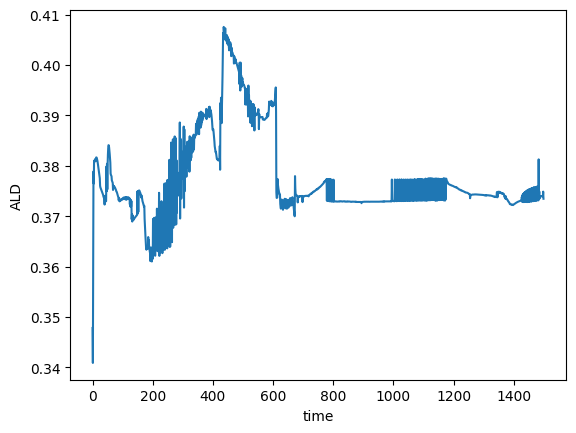

In [248]:
#CMT1 with shlwc, nfactor_s from CMT13
sns.lineplot(data=ald_bs_eq, x='time', y='ALD')

<AxesSubplot:xlabel='time', ylabel='SHLWC'>

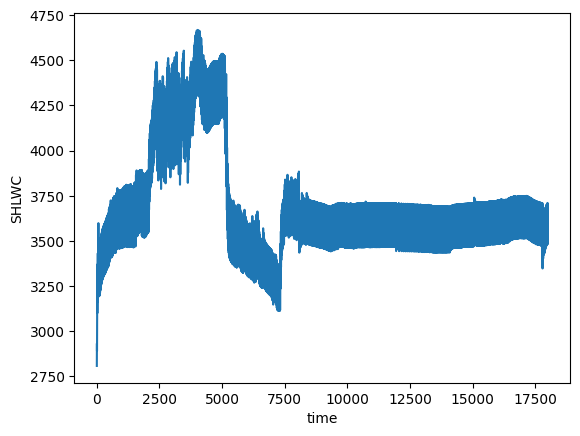

In [249]:
#CMT1 with shlwc, nfactor_s from CMT13
sns.lineplot(data=shlwc_bs_eq, x='time', y='SHLWC')

<AxesSubplot:xlabel='time', ylabel='ALD'>

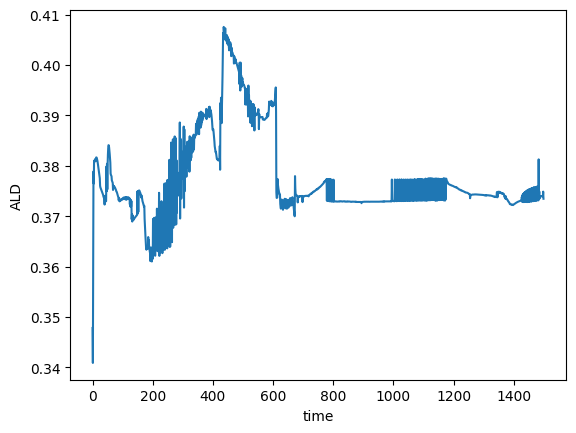

In [250]:
#CMT1
sns.lineplot(data=ald_bs_eq, x='time', y='ALD')

<AxesSubplot:xlabel='time', ylabel='SHLWC'>

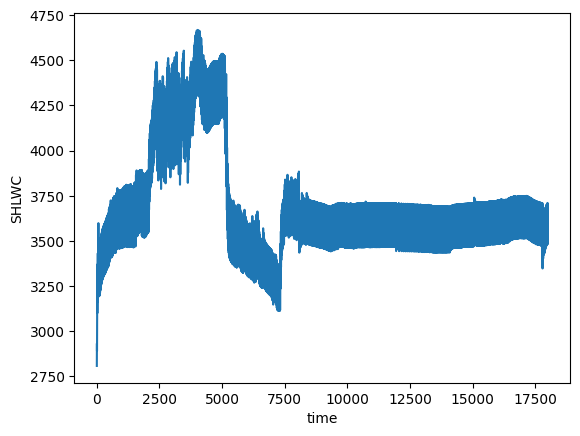

In [251]:
#CMT1
sns.lineplot(data=shlwc_bs_eq, x='time', y='SHLWC')

<AxesSubplot:xlabel='time', ylabel='AVLN'>

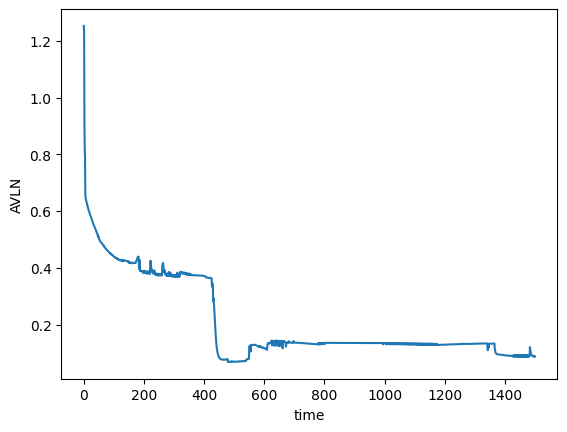

In [252]:
#CMT1
sns.lineplot(data=avln_bs_eq, x='time', y='AVLN')

In [253]:
avln_bs_tr.loc[100:]

,time,y,x,AVLN
100,2001-01-01 00:00:00,0,0,0.093773
101,2002-01-01 00:00:00,0,0,0.120456
102,2003-01-01 00:00:00,0,0,0.100116
103,2004-01-01 00:00:00,0,0,0.116814
104,2005-01-01 00:00:00,0,0,0.101186
105,2006-01-01 00:00:00,0,0,0.174298
106,2007-01-01 00:00:00,0,0,0.134498
107,2008-01-01 00:00:00,0,0,0.139731
108,2009-01-01 00:00:00,0,0,0.174152
109,2010-01-01 00:00:00,0,0,0.152660


<AxesSubplot:xlabel='None', ylabel='AVLN'>

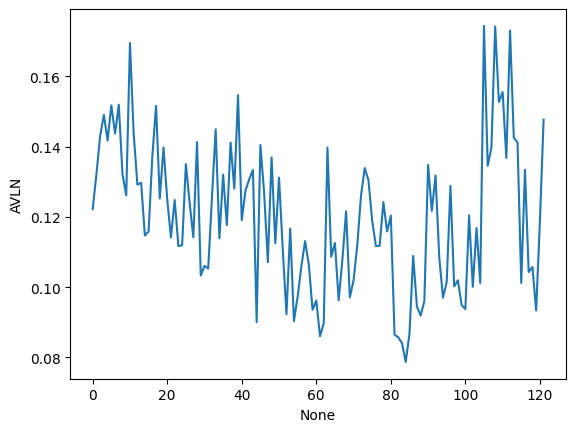

In [254]:
#0.708 nfactor(w)
sns.lineplot(data=avln_bs_tr, x=avln_bs_tr.index, y='AVLN')

<AxesSubplot:xlabel='None', ylabel='AVLN'>

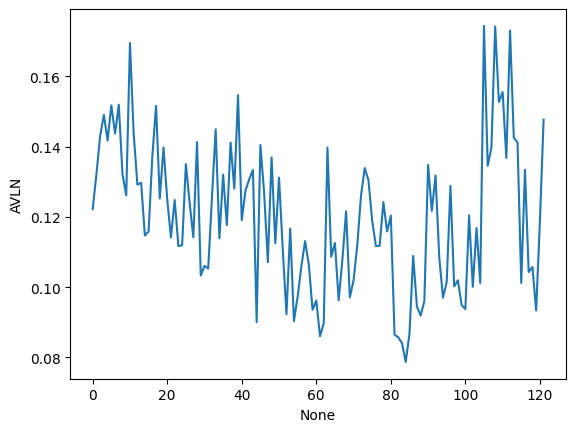

In [255]:
#0.707 nfactor(w)
sns.lineplot(data=avln_bs_tr, x=avln_bs_tr.index, y='AVLN')